In [1]:
import pandas as pd
import torch
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd

import numpy as np
%matplotlib inline

In [2]:
df=pd.read_csv("../../Integrated_data/merged_df_reward.csv",encoding="cp949")

In [3]:
import pandas as pd

class DataProcessor:
    def __init__(self, df):
        self.df = df
        self.interpolated()
        self.abmormaled()
        self.result=self.fill_missing_values()

    # ... (다른 클래스 함수 정의는 여기에 있어야 합니다)

    def interpolated(self):
        temp=[]
        temp2=[]
        for i in df['ID'].unique():
            try:
                temp.append(df[df['ID']==i].interpolate())
            except:
                temp.append(df[df['ID']==i])

        new_df=pd.concat(temp,axis=0)
        new_df.fillna(method='bfill',inplace=True)   
        for i in new_df['ID'].unique():
            temp_df=new_df[new_df['ID']==i].reset_index(drop=True)
            temp_df["height"].fillna(method='bfill',inplace=True)
            temp_df["weight"].fillna(method='bfill',inplace=True)
            temp_df["height"].fillna(method='ffill',inplace=True)
            temp_df["weight"].fillna(method='ffill',inplace=True)
            temp2.append(temp_df)
        new_df=pd.concat(temp2,axis=0)  
        self.df = new_df   
    def gap(self,first, last):
        gap_per=(last-first)/first*100
        return abs(gap_per)
        
    def abmormaled(self):
        temp = []
        for i in self.df['ID'].unique():
            temp_df = self.df[self.df['ID'] == i].reset_index(drop=True)
            for i in range(1, len(temp_df)):
                if temp_df.at[i, 'height'] <= temp_df.at[i - 1, 'height']:
                    temp_df.at[i, 'height'] = temp_df.at[i - 1, 'height']
                if self.gap(temp_df.at[i - 1, 'height'], temp_df.at[i, 'height']) >= 16:
                    temp_df.at[i, 'height'] = temp_df.at[i - 1, 'height']
            temp.append(temp_df)
        new_df2 = pd.concat(temp, axis=0)
        new_df2.reset_index(drop=True, inplace=True)
        self.df = new_df2

    def fill_missing_values(self):
        self.df["step_count"].fillna(self.df["step_count"].median(), inplace=True)
        self.df["burned calory"].fillna(self.df["burned calory"].median(), inplace=True)
        self.df["eat_calory"].fillna(self.df["eat_calory"].median(), inplace=True)
        self.df["Sleep_time"].fillna(self.df["Sleep_time"].median(), inplace=True)
        return self.df
    



In [4]:
import pandas as pd

class TimeSeriesLabeler:
    def __init__(self, term):
        self.term = term
        self.result_df = pd.DataFrame()
        self.labels = []

    def calculate_labels(self, df):
        for id in df['ID'].unique():
            df_id = df[df['ID'] == id].reset_index(drop=True)
            label = []

            for i in range(self.term, len(df_id)):
                previous_days = df_id['weight'].iloc[i - self.term:i]
                current_weight = df_id['weight'].iloc[i]
                if current_weight > previous_days.mean().round(3):
                    label.append(1)
                elif current_weight == previous_days.mean().round(3):
                    label.append(0)
                elif current_weight < previous_days.mean().round(3):
                    label.append(2)
                else:
                    print("error")

            self.labels.extend(label)

    def create_result_df(self, df):
        for id in df['ID'].unique():
            df_id = df[df['ID'] == id].reset_index(drop=True)
            df_id_drop = df_id.drop(index=range(self.term))
            self.result_df = pd.concat([self.result_df, df_id_drop])
        self.result_df['labels']= self.labels
        
    def get_labels(self):
        return self.labels

    def get_result_df(self):
        return self.result_df



In [5]:
for i in range(3):
    globals()['reward_data_{}'.format(i+1)]=pd.read_excel("../../Integrated_data/merged_df_reward_분리.xlsx",sheet_name = i)
    

In [6]:
# 데이터프레임 리스트 생성
dataframes = [reward_data_1, reward_data_2, reward_data_3]

# 반복문으로 데이터프레임 순차적으로 호출
for i, df in enumerate(dataframes, start=0):
    print(f"Processing reward_data_{i+1}")
    processor = DataProcessor(df)
    globals()['df_{}'.format(i+1)]=processor.result


Processing reward_data_1
Processing reward_data_2
Processing reward_data_3


# ID 별로 일주일 간격으로 몸무게 변화 라벨링(유지:0, 감소:2, 증가:1)

In [7]:
term = 7  # You can set your desired 'term' here

In [8]:
labeler_1 = TimeSeriesLabeler(term)
labeler_1.calculate_labels(df_1)  # Provide your DataFrame 'df' as input
labeler_1.create_result_df(df_1)  # Create the result DataFrame
labels = labeler_1.get_labels()
result_df_1 = labeler_1.get_result_df()

labeler_2 = TimeSeriesLabeler(term)
labeler_2.calculate_labels(df_2)  # Provide your DataFrame 'df' as input
labeler_2.create_result_df(df_2)  # Create the result DataFrame
labels = labeler_2.get_labels()
result_df_2 = labeler_2.get_result_df()

labeler_3 = TimeSeriesLabeler(term)
labeler_3.calculate_labels(df_3)  # Provide your DataFrame 'df' as input
labeler_3.create_result_df(df_3)  # Create the result DataFrame
labels = labeler_3.get_labels()
result_df_3 = labeler_3.get_result_df()

In [9]:
result_df_3.head()

,ID,collect_datetime,gender,grade,height,weight,step_count,burned calory,eat_calory,Sleep_time,서포터여부,labels
7,#ASELLU,2022-07-21,2,6,164.0,64.0,4919.0,142.8,546.0,432.0,3,2
8,#ASELLU,2022-07-22,2,6,164.0,64.0,323.0,142.8,546.0,432.0,3,1
9,#ASELLU,2022-07-23,2,6,164.0,64.0,323.0,142.8,546.0,432.0,3,2
10,#ASELLU,2022-07-24,2,6,164.0,64.0,1898.0,142.8,546.0,432.0,3,2
11,#ASELLU,2022-07-25,2,6,164.0,64.0,1072.0,142.8,546.0,432.0,3,2


# 라이브러리

In [10]:
# Verify assigned Google Collab GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Nov 28 14:41:54 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.40                 Driver Version: 536.40       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070      WDDM  | 00000000:08:00.0  On |                  N/A |
|  0%   41C    P8              26W / 270W |   1277MiB /  8192MiB |     12%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [11]:
%matplotlib inline

# Load libraries
import math, random, copy, os, glob, time
from itertools import chain, combinations, permutations
from pprint import pprint

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision as tv
from torchvision import datasets, transforms as T

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Standardize randomness
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# 하이퍼 파라미터 정의

In [12]:
## USER DEFINED EXPERIMENT PARAMETERS

# Federated network settings
MODEL_SIZE = 'DNN_MODEL'            # SMALL / MEDIUM / LARGE
REWARD_METRICS = ['LOSS']       # LOSS / ACCURACY / F1 - Metrics sum to select best model for each communication round
COMM_ROUNDS = 3                 # Number of communication rounds between server and clients
SHAPLEY_FILTER = False           # True / False - If true, select only the best coalition model per communication round
COALITION_LIMIT = 0            # Limits the size of individual coalitions (Set as non-positive number to disable limit)

# Training dataset settings
#DATASET_TYPE = 'MNIST'      # MNIST / EMNIST
DISTRIBUTION_TYPE = 'Reward_shap'   # IID / NIID_1 / NIID_2 / NIID_12
BATCH_SIZE = 64             # Dataset batch size
CLASS_SIZE=3
INPUT_DIM=8
# Training hyper-parameters and functions for the Federated modeel
INIT_LEARN_RATE = 0.1
LOSS_FUNC = nn.CrossEntropyLoss
OPTIMIZER = torch.optim.SGD
MOMENTUM = .9
WEIGHT_DECAY = 1e-5
EPOCHS = 50                 # Number of epochs each client will train over

# Client behaviours each parameter represents the number of clients running in the network
NUM_NORMAL_CLIENTS = 3          # Client trains model and returns updated parameters
NUM_FREERIDER_CLIENTS = 0       # Client does not train model and returns original parameters
NUM_ADVERSARIAL_CLIENTS = 0     # Client returns randomized parameters 

In [13]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Create subdirectories
model_path = './models'

def createDirectory(path):
    pathExists = os.path.exists(path)
    if not pathExists:
        print(f'"{path}" does not exist.')
        os.makedirs(path)
        print(f'"{path}" created.')
        
createDirectory(model_path)

# Delete existing .pt files from previous run
def deleteAllModels(path):
    filepaths = glob.glob(f'{path}/**/*.pt', recursive=True)
    for filepath in filepaths:
        os.remove(filepath)
        print(f'"{filepath}" deleted.')
        
deleteAllModels(model_path)

# Complete
print('\nLibraries and directories initialized.')

Using cuda device
"./models\FedAvg\client\client_0.pt" deleted.
"./models\FedAvg\client\client_1.pt" deleted.
"./models\FedAvg\client\client_2.pt" deleted.
"./models\FedAvg\server\server_model.pt" deleted.
"./models\ShapleyValue\client\client_0.pt" deleted.
"./models\ShapleyValue\client\client_1.pt" deleted.
"./models\ShapleyValue\client\client_2.pt" deleted.
"./models\ShapleyValue\server\server_model.pt" deleted.

Libraries and directories initialized.


In [14]:
# Helper functions

# Recipe modified from Python itertools documentation: 
# https://docs.python.org/3/library/itertools.html#itertools-recipes
def powerset(iterable, no_null = True):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1 if no_null else 0, len(s)+1))

def aggListOfDicts(lst):
    '''
        Combines a list of dictionaries into a dictionary of lists
    '''
    agg = {}
    for dct in lst:
        for name, val in dct.items():
            if name in agg:
                agg[name] += [val]
            else:
                agg[name] = [val]

    return agg

In [15]:
# Functions to split dataset based on IID or Non-IID selection

def prepareIID(dataset, num_clients):
    '''
        Prepares IID training datasets for each client
    '''
    dataset_split = [[] for i in range(num_clients)]
    
    for idx, sample in enumerate(dataset):
        dataset_split[idx%num_clients] += [sample]
    
    return dataset_split
    
def prepareNIID1(dataset, num_clients):
    '''
        Prepares NIID-1 training datasets for each client (Overlapping sample sets)
    '''
    dataset_split = [[] for i in range(num_clients)]
            
    for idx, sample in enumerate(dataset):
        dataset_split[idx%num_clients] += [random.choice(dataset)]
    
    return dataset_split

def prepareNIID2(dataset, num_clients):
    '''
        Prepares NIID-1 training datasets for each client (Unequal data distribution)
    '''
    dataset_split = [[] for i in range(num_clients)]
    
    for idx, sample in enumerate(dataset):
        dataset_split[random.randint(0,num_clients-1)] += [sample]
    
    return dataset_split

def prepareNIID12(dataset, num_clients):
    '''
        Prepares NIID-1+2 training datasets for each client 
        (Overlapping sample sets + Unequal data distribution)
    '''
    dataset_split = [[] for i in range(num_clients)]
    
    for sample in dataset:
        dataset_split[random.randint(0,num_clients-1)] += [random.choice(dataset)]
    
    return dataset_split

def prepareREWARD(client_dataset,num_clients):
    dataset_split = [[] for i in range(num_clients)]
    
    for idx, sample in enumerate(client_dataset):
        dataset_split[idx] += sample
    
    return dataset_split
    


# Train and Test dataset and dataloaders

In [16]:
X_1=result_df_1.iloc[:,[2,3,4,5,6,7,8,9]]
y_1=result_df_1.iloc[:,-1].to_frame()

X_2=result_df_2.iloc[:,[2,3,4,5,6,7,8,9]]
y_2=result_df_2.iloc[:,-1].to_frame()

X_3=result_df_3.iloc[:,[2,3,4,5,6,7,8,9]]
y_3=result_df_3.iloc[:,-1].to_frame()

## 데이터 스케일링

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder

scaler_1 = StandardScaler()
scaler_2 = StandardScaler()
scaler_3 = StandardScaler()

X_scaler_1=scaler_1.fit_transform(X_1)
X_scaler_2= scaler_2.fit_transform(X_2)
X_scaler_3= scaler_3.fit_transform(X_3)

## Train, Test dataset 나누기

In [18]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_scaler_1, y_1, test_size=0.20)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_scaler_2, y_2, test_size=0.20)

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_scaler_3, y_3, test_size=0.20)

## Global train 데이터 세트 만들기

In [19]:
X_train = np.concatenate((X_train_1,X_train_2,X_train_3), axis=0)
y_train = np.concatenate((y_train_1,y_train_2,y_train_3), axis=0)

X_test = np.concatenate((X_test_1,X_test_2,X_test_3), axis=0)
y_test = np.concatenate((y_test_1,y_test_2,y_test_3), axis=0)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)
train_dataset=TensorDataset(X_train, y_train)
test_dataset=TensorDataset(X_test, y_test)

## Client train 데이터 세트 만들기

In [20]:
X_train_1 = torch.FloatTensor(X_train_1)
X_test_1 = torch.FloatTensor(X_test_1)
y_train_1 = torch.LongTensor(y_train_1.to_numpy())
y_test_1 = torch.LongTensor(y_test_1.to_numpy())

train_dataset_1=TensorDataset(X_train_1, y_train_1)
test_dataset_1=TensorDataset(X_test_1, y_test_1)

In [21]:
X_train_2 = torch.FloatTensor(X_train_2)
X_test_2 = torch.FloatTensor(X_test_2)
y_train_2 = torch.LongTensor(y_train_2.to_numpy())
y_test_2 = torch.LongTensor(y_test_2.to_numpy())

train_dataset_2=TensorDataset(X_train_2, y_train_2)
test_dataset_2=TensorDataset(X_test_2, y_test_2)

In [22]:
X_train_3 = torch.FloatTensor(X_train_3)
X_test_3 = torch.FloatTensor(X_test_3)
y_train_3 = torch.LongTensor(y_train_3.to_numpy())
y_test_3 = torch.LongTensor(y_test_3.to_numpy())

train_dataset_3=TensorDataset(X_train_3, y_train_3)
test_dataset_3=TensorDataset(X_test_3, y_test_3)

In [23]:
client_datasets=[train_dataset_1,train_dataset_2,train_dataset_3]

In [24]:
# Split training dataset for clients
NUM_OF_CLIENTS = NUM_NORMAL_CLIENTS + NUM_FREERIDER_CLIENTS + NUM_ADVERSARIAL_CLIENTS
if DISTRIBUTION_TYPE == 'Reward_shap':
    train_datasets = prepareREWARD(client_datasets, NUM_OF_CLIENTS)
#elif DISTRIBUTION_TYPE == 'NIID_12':
    #train_datasets = prepareNIID12(train_data, NUM_OF_CLIENTS)

train_dataloaders = [DataLoader(train_dataset, batch_size=BATCH_SIZE) for train_dataset in train_datasets]

# Sanity check a training dataloader
for X, y in train_dataloaders[1]:
    print(f"Shape of X [N, feature_num]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, feature_num]: torch.Size([64, 8])
Shape of y: torch.Size([64, 1]) torch.int64


In [25]:
# Create test dataloader.
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Sanity check test dataloader
for X, y in test_dataloader:
    print(f"Shape of X [N, feature_num]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, feature_num]: torch.Size([64, 8])
Shape of y: torch.Size([64, 1]) torch.int64


## Define neural nework models

In [26]:
class DNNModel(torch.nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.input_layer = nn.Linear(INPUT_DIM, 128)
        self.hidden_layer1 = nn.Linear(128, 256)
        self.hidden_layer2 = nn.Linear(256, 128)
        self.output_layer   = nn.Linear(128,CLASS_SIZE)
        self.relu = nn.ReLU()
        self.track_layers = {'hidden_layer1': self.hidden_layer1, 'hidden_layer2': self.hidden_layer2, 'output_layer': self.output_layer}

    def forward(self, x):
        out =  self.relu(self.input_layer(x))
        out =  self.relu(self.hidden_layer1(out))
        out =  self.relu(self.hidden_layer2(out))
        out =  self.output_layer(out)
        return out 

In [27]:
# Define checkpoint functions (Simulates data exchange between clients and server)
    
def saveCheckpoint(name, model_state_dict, optimizer_state_dict, filepath, verbose=False):
    '''
        Saves state dictionaries of model and optimizer as a .pt file
    '''
    torch.save({
        'name': name,
        'model_state_dict': model_state_dict,
        'optimizer_state_dict': optimizer_state_dict,
    }, filepath)
    
    if verbose:
        print(f'\n"{name}" model saved as "{filepath}".\n')
        
    return True
    
def loadCheckpoint(filepath, verbose=False):
    '''
        Loads and returns the state dictionaries of model and optimizer from a .pt file
    '''
    checkpoint = torch.load(filepath)
    
    if verbose:
        name = checkpoint['name']
        print(f'\n"{name}" model loaded from "{filepath}".\n')
    
    return checkpoint

def print_parameters(model):
    '''
        Outputs the learnable parameter counts for each layer and in total
    '''
    print('Model Layer Parameters:\n')
    total_params = 0
    for name, parameter in model.named_parameters():
            if not parameter.requires_grad:
                continue
            params = parameter.numel()
            print(f'{name} - {params} parameters')
            total_params += params
    print(f'\n>>Total - {total_params} parameters\n')

## Initialize Federated Model and hyper-parameters

In [28]:
# Define network model architecture
FederatedModel = None

if MODEL_SIZE == 'DNN_MODEL':
    FederatedModel = DNNModel
elif MODEL_SIZE == 'MEDIUM':
    FederatedModel = MediumMLP
elif MODEL_SIZE == 'LARGE':
    FederatedModel = LargeMLP
    
print_parameters(FederatedModel())

# Define network training functions and hyper-parameters
FederatedLossFunc = LOSS_FUNC
FederatedOptimizer = OPTIMIZER
FederatedLearnRate = INIT_LEARN_RATE
FederatedMomentum = MOMENTUM
FederatedWeightDecay = WEIGHT_DECAY

Model Layer Parameters:

input_layer.weight - 1024 parameters
input_layer.bias - 128 parameters
hidden_layer1.weight - 32768 parameters
hidden_layer1.bias - 256 parameters
hidden_layer2.weight - 32768 parameters
hidden_layer2.bias - 128 parameters
output_layer.weight - 384 parameters
output_layer.bias - 3 parameters

>>Total - 67459 parameters



## Server functions

In [29]:
def initServer(model_path,folder_name,dataloader):
    '''
        Initializes server model and returns object with attributes
    '''
    print('Initializing server model...')
    # Spawn server model and functions
    server_name = 'server'
    server_model = FederatedModel().to(device)
    server_loss_func = FederatedLossFunc()
    server_optimizer = FederatedOptimizer(server_model.parameters(), lr=FederatedLearnRate, momentum=FederatedMomentum, weight_decay=FederatedWeightDecay)
    server_dataloader = dataloader

    print(server_model,'\n')
    print(server_optimizer)

    createDirectory(f'{model_path}/{folder_name}/server')
    createDirectory(f'{model_path}/{folder_name}/client')

    # Collect objects into a reference dictionary
    server = {
        'name': server_name,
        'model': server_model,
        'dataloader': server_dataloader,
        'optimizer': server_optimizer,
        'loss_func': server_loss_func,
        'filepath': f'{model_path}/{folder_name}/server/server_model.pt',
        'client_filepath': f'{model_path}/{folder_name}/client'
    }

    # Save server model state_dicts (simulating public access to server model parameters)
    saveCheckpoint(
        server_name,
        server_model.state_dict(),
        server_optimizer.state_dict(),
        server['filepath'],
        verbose=True
    )

    return server

## Clients functions

In [30]:
def initClients(num_norm,num_free,num_avsl,server,dataloaders):
  '''
      Initializes clients objects and returns a list of client object
  '''

  print('Initializing clients...')
  # Setup client devices
  behaviour_list = [
      *['NORMAL' for i in range(num_norm)],
      *['FREERIDER' for i in range(num_free)],
      *['ADVERSARIAL' for i in range(num_avsl)],
  ]

  clients = []
  for n, behaviour in enumerate(behaviour_list):     
      # Spawn client model and functions
      client_name = f'client_{n}'
      
      # Collect client's objects into a reference dictionary
      clients += [{
          'name': client_name,
          'behaviour': behaviour,
          'filepath': f'{server["client_filepath"]}/{client_name}.pt',
          'dataloader': dataloaders[n]
      }]
      
  print('Client Name / Behaviour:', [(client['name'], client['behaviour']) for client in clients], '\n')

  return clients

## Define train and test functions

In [31]:
def train(dataloader, model, loss_fn, optimizer, verbose=False):
    '''
        Trains a NN model over a dataloader
    '''
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        y=y.squeeze()
        loss = loss_fn(pred, y.squeeze())
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
 
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)

        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            
            if verbose:
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
            return loss

In [32]:
def test(dataloader, model, loss_fn, verbose=False):
    '''
        Tests a NN model over a dataloader
    '''
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    
    test_loss, correct, f1 = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y.squeeze()).item()
            correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()
            f1 += f1_score(y.cpu(), y_pred.argmax(1).cpu(), average='micro')

    test_loss /= num_batches
    correct /= size
    f1 /= num_batches
    
    if verbose:
        print(f"Test Error: \n Accuracy: {correct:>8f}, Avg loss: {test_loss:>8f}, F1: {f1:>8f} \n")
        
    return test_loss, correct, f1

### Client training functions

In [33]:
def trainClients(clients, server):
    '''
        Trains a list of client devices and saves their parameters
    '''
    loss, acc, f1 = {}, {}, {}
    for client in clients:
        train_loss, test_loss, test_acc, test_f1 = trainClient(client, server)

        # Aggregate statistics
        loss[client['name']] = test_loss
        acc[client['name']] = test_acc
        f1[client['name']] = test_f1
    
    return loss, acc, f1

def trainClient(client, server):
    '''
        Trains a client device and saves its parameters
    '''
    # Read client behaviour setting
    client_behaviour = client['behaviour']
    
    # Load local dataset
    client_dataloader = client['dataloader']
    
    # Get client model and functions
    client_name = client['name']
    client_model = FederatedModel().to(device)
    client_loss_fn = FederatedLossFunc()
    client_optimizer = FederatedOptimizer(client_model.parameters(), lr=FederatedLearnRate, momentum=FederatedMomentum, weight_decay=FederatedWeightDecay)
    
    # If client is adversarial, they return randomized parameters
    if client_behaviour == 'ADVERSARIAL':
        # Save client model state_dicts (simulating client uploading model parameters to server)
        saveCheckpoint(
            client_name,
            client_model.state_dict(),
            client_optimizer.state_dict(),
            client['filepath'],
        )
        
        test_loss, test_acc, test_f1 = test(server['dataloader'], client_model, client_loss_fn)
        print(f"{client_name} ({client_behaviour}) Test Acc: {test_acc:>8f}, Loss: {test_loss:>8f}, F1: {test_f1:>8f}")
        
        return 0, test_loss, test_acc, test_f1
    
    # Load server model state_dicts (simulating client downloading server model parameters)
    checkpoint = loadCheckpoint(server['filepath'])
    client_model.load_state_dict(checkpoint['model_state_dict']) # Using current server model parameters
    # client_optimizer.load_state_dict(checkpoint['optimizer_state_dict']) # Using current server model parameters
    
    # If client is a freeloader, they return the same server model parameters
    if client_behaviour == 'FREERIDER':
        # Save client model state_dicts (simulating client uploading model parameters to server)
        saveCheckpoint(
            client_name,
            client_model.state_dict(),
            client_optimizer.state_dict(),
            client['filepath'],
        )
        
        test_loss, test_acc, test_f1 = test(server['dataloader'], client_model, client_loss_fn)
        print(f"{client_name} ({client_behaviour}) Test Acc: {test_acc:>8f}, Loss: {test_loss:>8f}, F1: {test_f1:>8f}")
        
        return 0, test_loss, test_acc, test_f1
    
    # If client is normal, they train client over N epochs
    epochs = EPOCHS
    print(f'Training {client_name} over {epochs} epochs...')
    for t in range(epochs):
        train_loss = train(client_dataloader, client_model, client_loss_fn, client_optimizer)

    test_loss, test_acc, test_f1 = test(server['dataloader'], client_model, client_loss_fn)
    print(f"{client_name} ({client_behaviour}) Test Acc: {test_acc:>8f}, Loss: {test_loss:>8f}, F1: {test_f1:>8f}")

    # Save client model state_dicts (simulating client uploading model parameters to server)
    saveCheckpoint(
        client_name,
        client_model.state_dict(),
        client_optimizer.state_dict(),
        client['filepath'],
    )

    return train_loss, test_loss, test_acc, test_f1

### FedAvg core function

In [34]:
def FedAvg(model_state_dicts):
    '''
        Calculates and generates the FedAvg of the state_dict of a list of models. Returns the FedAvg state_dict.
    '''
    # Sum up tensors from all states
    state_dict_sum = {} # Stores the sum of state parameters
    for state_dict in model_state_dicts:
        for key, params in state_dict.items():
            if key in state_dict_sum:
                state_dict_sum[key] += params.detach().clone()
            else:
                state_dict_sum[key] = params.detach().clone()
                
    # Get Federated Average of clients' parameters
    state_dict_avg = {}
    for key in state_dict_sum:
        state_dict_avg[key] = state_dict_sum[key] / len(model_state_dicts)

    return state_dict_avg

### Naive FedAvg server training functions

In [35]:
def evalFedAvg(server):  
    '''
        Load client state dicts, perform parameter aggregation and evaluate contributions for each client
    '''
    # Retrieve all clients' uploaded data
    client_filepaths = glob.glob(f"{server['client_filepath']}/client*.pt")
    
    # Load client model state_dicts (simulating client downloading server model parameters)
    client_checkpoints = []
    for client_filepath in client_filepaths:
        client_checkpoint = loadCheckpoint(client_filepath)
        client_checkpoints += [client_checkpoint]
                
    # Get Federated Average of clients' parameters
    model_state_dicts = [checkpoint['model_state_dict'] for checkpoint in client_checkpoints]
    fed_model_state_dict = FedAvg(model_state_dicts)

    # Instantiate server model using FedAvg
    fed_model = FederatedModel().to(device)
    fed_model.load_state_dict(fed_model_state_dict)
    fed_model.eval()

    # Evaluate FedAvg server model
    start_time = time.time() # Time evaluation period
    eval_loss, eval_acc, eval_f1 = test(server['dataloader'], fed_model, server['loss_func'])
    time_taken = time.time() - start_time # Get model evaluation period (in seconds)
    print(f"\n>> Federated Model Acc: {eval_acc:>8f}, Loss: {eval_loss:>8f}, F1: {eval_f1:>8f}\n")
    
    # Save server model state_dicts (simulating public access to server model parameters)
    saveCheckpoint(
        server['name'],
        fed_model.state_dict(),
        server['optimizer'],
        server['filepath'],
    )

    # Output statistics
    return eval_loss, eval_acc, eval_f1, time_taken

In [36]:
def trainFedAvgModel(rounds=5):
    '''
        Train a model using naive FedAvg
    '''
    
    loss, acc, f1, eval_time = [], [], [], []
    for i in range(rounds):
        print(f'\n=======================\n\tROUND {i+1}\n=======================')
        clients_loss, clients_acc, clients_f1 = trainClients(clients, server)
        server_loss, server_acc, server_f1, time_taken = evalFedAvg(server)

        # Compile performance measures 
        loss += [{ **clients_loss, **{'server': server_loss} }]
        acc += [{ **clients_acc, **{'server': server_acc} }]
        f1 += [{ **clients_f1, **{'server': server_f1} }]
        eval_time += [time_taken]

    # Output statistics
    return aggListOfDicts(loss), aggListOfDicts(acc), aggListOfDicts(f1), eval_time

### FedAvg-Shapley server training functions

In [37]:
def evalFedAvgShapley(server, shapley_filter=True, coalition_limit=0):
    '''
        Evaluates and rewards clients based on marginal contributions in coalition permutations
    '''

    # Evaluate current server model performance
    server_checkpoint = loadCheckpoint(server['filepath'])
    server_model = FederatedModel().to(device)
    server_model.load_state_dict(server_checkpoint['model_state_dict'])
    
    # Evaluate server model
    server_loss, server_acc, server_f1 = test(server['dataloader'], server_model, server['loss_func'])

    print(f"\n>> Current Server Model Acc: {server_acc:>8f}, Loss: {server_loss:>8f}, F1: {server_f1:>8f}\n")

    # Coalition Limit only valid if Shapley Filter is True
    if not shapley_filter:
        coalition_limit = 0
        
    # Load client model state_dicts (simulating server sideloading client model parameters)
    client_filepaths = glob.glob(f"{server['client_filepath']}/client*.pt")

    client_checkpoints = {}
    for client_filepath in client_filepaths:
        client_checkpoint = loadCheckpoint(client_filepath)
        client_checkpoints[client_checkpoint['name']] = client_checkpoint
    client_names = [client_id for client_id in client_checkpoints]

    # We generate non-null powerset of selected clients
    coalitions = list([frozenset(subset) for subset in powerset(client_names)])

    # We prune number of coalitions based on Coalition Limit parameter
    if coalition_limit > 0:
        limited_coalitions = []
        for coalition in coalitions:
            if len(coalition) <= coalition_limit:
                limited_coalitions += [coalition]
        coalitions = limited_coalitions

    # We generate order permutations of selected clients
    orders = list(permutations(client_names))

    # We prune length of coalitions based on Coalition Limit parameter
    if coalition_limit > 0:
        orders = list(set([order[:coalition_limit] for order in orders]))

    # We calculate the contributions of each coalition
    print('FedAvg Coalition Evaluations:')

    best_model_state_dict, best_name = server_checkpoint['model_state_dict'], 'server' # We keep track of the best performing model
    best_loss, best_acc, best_f1, best_utility = server_loss, server_acc, server_f1, 0.0
    utilities = {}

    fed_model = FederatedModel().to(device)

    time_taken = 0 # Get model evaluation period (in seconds)
    for coalition in coalitions:
        # Keep track of largest coalition
        is_largest_coalition = False
        if len(coalition) == len(client_names):
            is_largest_coalition = True

        coalition_names = [client_id for client_id in coalition]
                    
        # Get Federated Average of clients' parameters
        model_state_dicts = [client_checkpoints[client_id]['model_state_dict'] for client_id in coalition_names]
        fed_model_state_dict = FedAvg(model_state_dicts)

        # Instantiate server model using FedAvg
        fed_model.load_state_dict(fed_model_state_dict)
        fed_model.eval()
        
        # Evaluate FedAvg server model
        start_time = time.time() # Time evaluation period
        eval_loss, eval_acc, eval_f1 = test(server['dataloader'], fed_model, FederatedLossFunc())
        time_taken += time.time() - start_time # Accumulate model evaluation period (in seconds)

        print(f">> {'-'.join(coalition_names)} Acc: {eval_acc:>8f}, Loss: {eval_loss:>8f}, F1: {eval_f1:>8f}")
        
        # Evaluate marginal contributions (Coalition model metrics - Server model metrics) > 0
        utility_loss = max(0, server_loss - eval_loss) # Reversed because lower loss == better performance
        utility_acc = max(0, eval_acc - server_acc)
        utility_f1 = max(0, eval_f1 - server_f1)
        
        utility_sum = 0
        for metric in REWARD_METRICS:
            if metric == 'LOSS': utility_sum += utility_loss
            elif metric == 'ACC': utility_sum += utility_acc
            elif metric == 'F1': utility_sum += utility_f1
        
        # Using Shapley Filter, keep the best model and statistics 
        if shapley_filter:
            if utility_sum > best_utility:
                best_name = '-'.join(coalition_names)
                best_model_state_dict = fed_model_state_dict
                best_utility = utility_sum
                best_loss, best_acc, best_f1 = eval_loss, eval_acc, eval_f1
        # Otherwise, the largest coalition is the best model
        else:
            if is_largest_coalition:
                best_name = '-'.join(coalition_names)
                best_model_state_dict = fed_model_state_dict
                best_utility = utility_sum
                best_loss, best_acc, best_f1 = eval_loss, eval_acc, eval_f1
        
        utilities[coalition] = {
            'loss': utility_loss,
            'acc': utility_acc,
            'f1': utility_f1,
            'sum': utility_sum
        }

    print(f'\nFedAvg Coalition Contributions:')
    for coalition in utilities:
        coalition_names = [client_id for client_id in coalition]
        print(f">> '{'-'.join(coalition_names)}' Acc: {utilities[coalition]['acc']:>8f}, Loss: {utilities[coalition]['loss']:>8f}, F1: {utilities[coalition]['f1']:>8f}, Sum: {utilities[coalition]['sum']:>8f}")

    # Save server model state_dicts (simulating public access to server model parameters)
    print(f'\nBest Coalition: {best_name}. Utility Sum: {best_utility:>8f}. Saving Coalition Model as Server Model.')
    saveCheckpoint(
        server['name'],
        best_model_state_dict,
        server['optimizer'],
        server['filepath'],
    )

    # We calculate the contributions of each client in order using utility
    contributions = {}
    for order in orders:
        index = 1
        prev_suborder = []
        
        # Calculate contribution of each client in this order
        for client_id in order:
            cur_suborder = order[:index] # eg. ['A'] -> ['A','B'] -> ['A','B','C']
            
            # If index > 1, we deduct this suborder's utility from prev suborder (eg. u(AB) - u(A) = c(B))
            if index > 1:
                cur_utilities = utilities[frozenset(cur_suborder)]
                prev_utilities = utilities[frozenset(prev_suborder)]
                
                ans = {}
                for utility_metric in cur_utilities:
                    ans[utility_metric] = max(0,cur_utilities[utility_metric] - prev_utilities[utility_metric])
                
            # If index == 1, this is a single element's contribution (eg. u(A) = c(A))
            else:
                ans = utilities[frozenset([client_id])]

            # Add value to client's list of contributions
            if not client_id in contributions:
                    contributions[client_id] = {}
            
            for utility_metric in ans:                
                if utility_metric in contributions[client_id]:
                    contributions[client_id][utility_metric] += [ans[utility_metric]]
                else:
                    contributions[client_id][utility_metric] = [ans[utility_metric]]

            index += 1
            prev_suborder += [client_id]

    # We calculate the Shapley Value of each client by averaging the sum of their contributions
    print(f'\nClient Shapley Values:')
    for client_id in contributions:
        txt = f'>> {client_id}:'
        for metric in contributions[client_id]:
            print('----------------------------------------------')
            print("metric:",metric)
            print('----------------------------------------------')
            metric_values = contributions[client_id][metric]
            print('----------------------------------------------')
            print("contributions:",contributions[client_id][metric])
            print('----------------------------------------------')
            contributions[client_id][metric] = sum(metric_values) / len(metric_values)
            print(f' {metric}: {contributions[client_id][metric]:>8f},')
            txt += f' {metric}: {contributions[client_id][metric]:>8f},'
        print(txt)

    # Output statistics
    return best_loss, best_acc, best_f1, time_taken, best_name, {name:vals['sum'] for name, vals in contributions.items()}

In [38]:
def trainFedAvgShapleyModel(rounds=5, shapley_filter=True, coalition_limit=0):
    '''
        Train a model using FedAvg using Shapley Value
    '''

    loss, acc, f1, eval_time, best_coalitions, sv = [], [], [], [], [], []
    for i in range(rounds):
        print(f'\n=======================\n\tROUND {i+1}\n=======================')
        clients_loss, clients_acc, clients_f1 = trainClients(clients, server)
        server_loss, server_acc, server_f1, time_taken, best_coalition, clients_sv = evalFedAvgShapley(server, shapley_filter, coalition_limit)

        # Compile performance measures 
        loss += [{ **clients_loss, **{'server': server_loss} }]
        acc += [{ **clients_acc, **{'server': server_acc} }]
        f1 += [{ **clients_f1, **{'server': server_f1} }]
        eval_time += [time_taken]
        best_coalitions += [best_coalition]   # Name of best coalition (string)
        sv += [clients_sv]              # Shapley Values of every client

    # Output statistics
    return aggListOfDicts(loss), aggListOfDicts(acc), aggListOfDicts(f1), eval_time, best_coalitions, aggListOfDicts(sv)

## Train a Naive FedAvg model

In [39]:
# Initalize server and clients
server = initServer(model_path,'FedAvg',test_dataloader)
clients = initClients(NUM_NORMAL_CLIENTS,NUM_FREERIDER_CLIENTS,NUM_ADVERSARIAL_CLIENTS,server,train_dataloaders)

Initializing server model...
DNNModel(
  (input_layer): Linear(in_features=8, out_features=128, bias=True)
  (hidden_layer1): Linear(in_features=128, out_features=256, bias=True)
  (hidden_layer2): Linear(in_features=256, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=3, bias=True)
  (relu): ReLU()
) 

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0.9
    nesterov: False
    weight_decay: 1e-05
)

"server" model saved as "./models/FedAvg/server/server_model.pt".

Initializing clients...
Client Name / Behaviour: [('client_0', 'NORMAL'), ('client_1', 'NORMAL'), ('client_2', 'NORMAL')] 



In [40]:
# Train and evaluate
fedavg_loss, fedavg_acc, fedavg_f1, fedavg_time = trainFedAvgModel(COMM_ROUNDS)


	ROUND 1
Training client_0 over 50 epochs...
client_0 (NORMAL) Test Acc: 55.305606, Loss: 0.932863, F1: 0.865565
Training client_1 over 50 epochs...
client_1 (NORMAL) Test Acc: 54.627396, Loss: 0.783049, F1: 0.853824
Training client_2 over 50 epochs...
client_2 (NORMAL) Test Acc: 40.784810, Loss: 1.472108, F1: 0.656535

>> Federated Model Acc: 55.459313, Loss: 0.653526, F1: 0.867010


	ROUND 2
Training client_0 over 50 epochs...
client_0 (NORMAL) Test Acc: 53.347559, Loss: 1.793275, F1: 0.840533
Training client_1 over 50 epochs...
client_1 (NORMAL) Test Acc: 50.818897, Loss: 1.614587, F1: 0.801148
Training client_2 over 50 epochs...
client_2 (NORMAL) Test Acc: 40.690416, Loss: 2.567345, F1: 0.655451

>> Federated Model Acc: 52.618987, Loss: 1.248926, F1: 0.829056


	ROUND 3
Training client_0 over 50 epochs...
client_0 (NORMAL) Test Acc: 53.113472, Loss: 2.032874, F1: 0.838185
Training client_1 over 50 epochs...
client_1 (NORMAL) Test Acc: 51.133635, Loss: 1.742408, F1: 0.800786
Traini

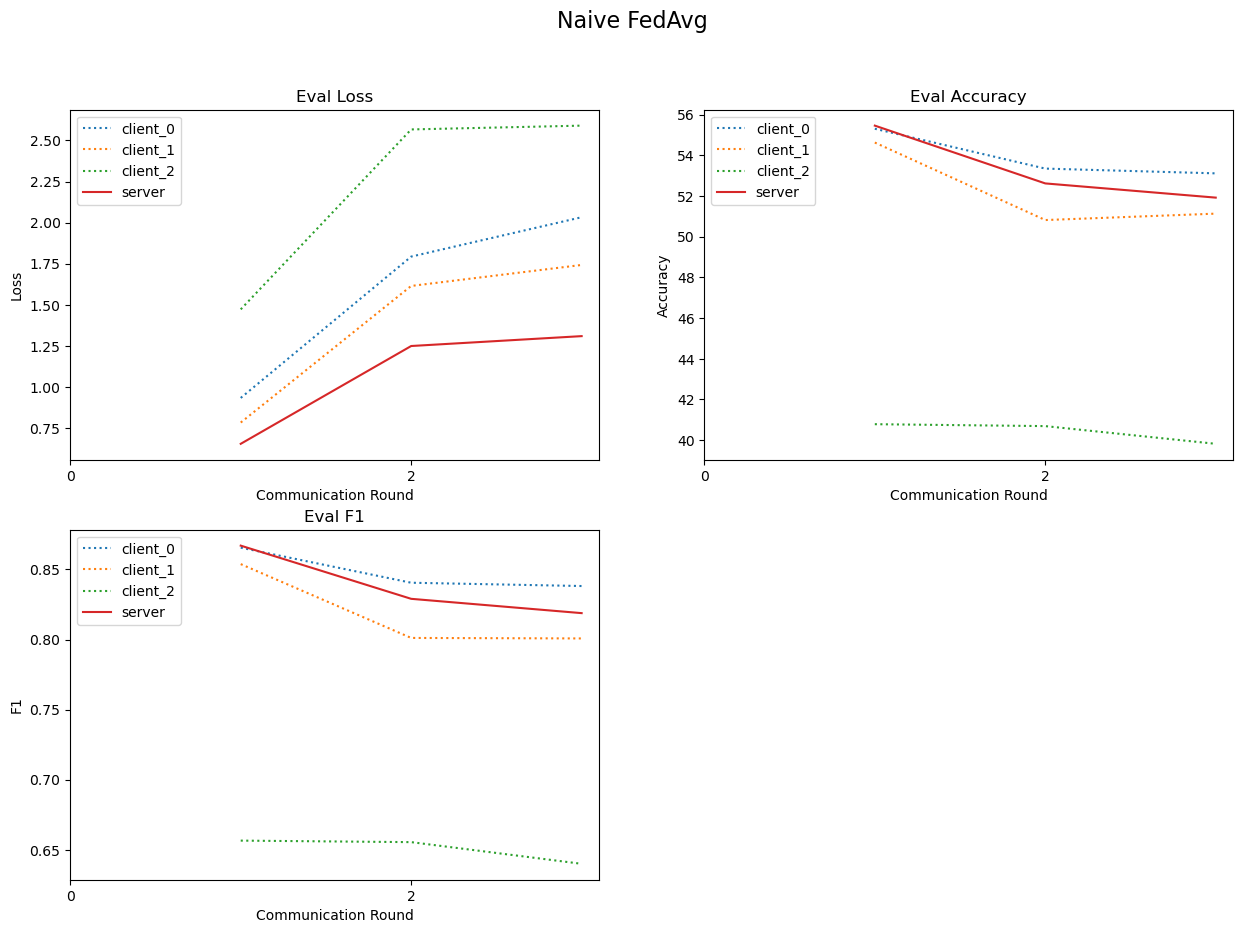

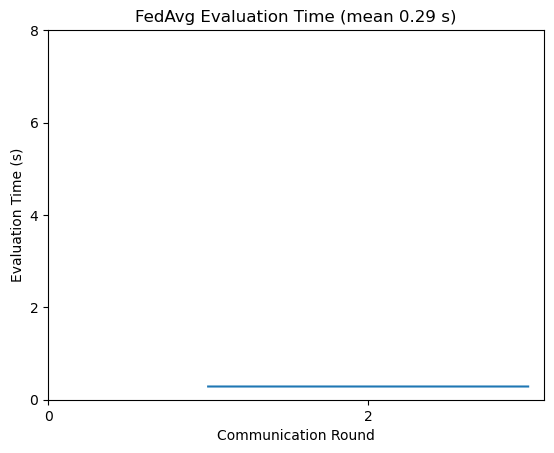

In [41]:
# Plot evaluation metric figures
figure = plt.figure(figsize=(15, 10))

# Plot Training Loss
figure.add_subplot(2, 2, 1)
for name, ts in fedavg_loss.items():
    if name == 'server':
        plt.plot(range(1,len(ts)+1), ts, label=name)
    else:
        plt.plot(range(1,len(ts)+1), ts, ':', label=name)
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('Loss')
plt.legend()
plt.title('Eval Loss')

# Plot Training Accuracy
figure.add_subplot(2, 2, 2)
for name, ts in fedavg_acc.items():
    if name == 'server':
        plt.plot(range(1,len(ts)+1), ts, label=name)
    else:
        plt.plot(range(1,len(ts)+1), ts, ':', label=name)
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Eval Accuracy')

# Plot Training F1
figure.add_subplot(2, 2, 3)
for name, ts in fedavg_f1.items():
    if name == 'server':
        plt.plot(range(1,len(ts)+1), ts, label=name)
    else:
        plt.plot(range(1,len(ts)+1), ts, ':', label=name)
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('F1')
plt.legend()
plt.title('Eval F1')

figure.suptitle('Naive FedAvg', fontsize=16)
plt.show()

# Plot Evaluation Time
total_time = sum(fedavg_time)
plt.plot(range(1,len(fedavg_time)+1), fedavg_time)
plt.xticks(np.arange(0, len(fedavg_time)+1, 2))
plt.yticks(np.arange(0, 10, 2))
plt.xlabel('Communication Round')
plt.ylabel('Evaluation Time (s)')
plt.title(f'FedAvg Evaluation Time (mean {total_time/len(fedavg_time):.2f} s)')
plt.show()

## Train a FedAvg-Shapley model

In [42]:
# Initalize server and clients
server = initServer(model_path,'ShapleyValue',test_dataloader)
clients = initClients(NUM_NORMAL_CLIENTS,NUM_FREERIDER_CLIENTS,NUM_ADVERSARIAL_CLIENTS,server,train_dataloaders)

# Train and evaluate
sv_loss, sv_acc, sv_f1, sv_time, sv_best_coalitions, sv  = trainFedAvgShapleyModel(COMM_ROUNDS, shapley_filter=SHAPLEY_FILTER, coalition_limit=COALITION_LIMIT)

Initializing server model...
DNNModel(
  (input_layer): Linear(in_features=8, out_features=128, bias=True)
  (hidden_layer1): Linear(in_features=128, out_features=256, bias=True)
  (hidden_layer2): Linear(in_features=256, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=3, bias=True)
  (relu): ReLU()
) 

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0.9
    nesterov: False
    weight_decay: 1e-05
)

"server" model saved as "./models/ShapleyValue/server/server_model.pt".

Initializing clients...
Client Name / Behaviour: [('client_0', 'NORMAL'), ('client_1', 'NORMAL'), ('client_2', 'NORMAL')] 


	ROUND 1
Training client_0 over 50 epochs...
client_0 (NORMAL) Test Acc: 55.416637, Loss: 0.864481, F1: 0.866920
Training client_1 over 50 epochs...
client_1 (NORMAL) Test Acc: 55.191501, Loss: 0.697459, F1: 0.863759
Training client_2 over 50 epochs...
client_2 (NORMAL) Test Acc: 40.385805, Loss: 1.329003, F1: 0.648497

>> Current Server Mod

client_0 (NORMAL) Test Acc: 52.902622, Loss: 1.902541, F1: 0.831411
Training client_1 over 50 epochs...
client_1 (NORMAL) Test Acc: 50.508770, Loss: 1.752943, F1: 0.791393
Training client_2 over 50 epochs...
client_2 (NORMAL) Test Acc: 39.188246, Loss: 2.710550, F1: 0.629551

>> Current Server Model Acc: 50.695027, Loss: 1.228308, F1: 0.804719

FedAvg Coalition Evaluations:
>> client_0 Acc: 52.902622, Loss: 1.902541, F1: 0.831411
>> client_1 Acc: 50.508770, Loss: 1.752943, F1: 0.791393
>> client_2 Acc: 39.188246, Loss: 2.710550, F1: 0.629551
>> client_1-client_0 Acc: 52.147378, Loss: 1.559496, F1: 0.817551
>> client_2-client_0 Acc: 48.442134, Loss: 1.475147, F1: 0.768230
>> client_2-client_1 Acc: 47.921519, Loss: 1.470585, F1: 0.762311
>> client_2-client_1-client_0 Acc: 50.699367, Loss: 1.301070, F1: 0.802704

FedAvg Coalition Contributions:
>> 'client_0' Acc: 2.207595, Loss: 0.000000, F1: 0.026692, Sum: 0.000000
>> 'client_1' Acc: 0.000000, Loss: 0.000000, F1: 0.000000, Sum: 0.000000


In [43]:
0.29999768871792476+0.8106450088928412

1.110642697610766

In [44]:
test=[0.29999768871792476, 0.29999768871792476, 0.17868998999885055, 0.05934518644575437, 0.4344165469869712, 0.05934518644575437]

In [45]:
mean = sum(test) / len(test)

In [46]:
mean

0.22196538121886333

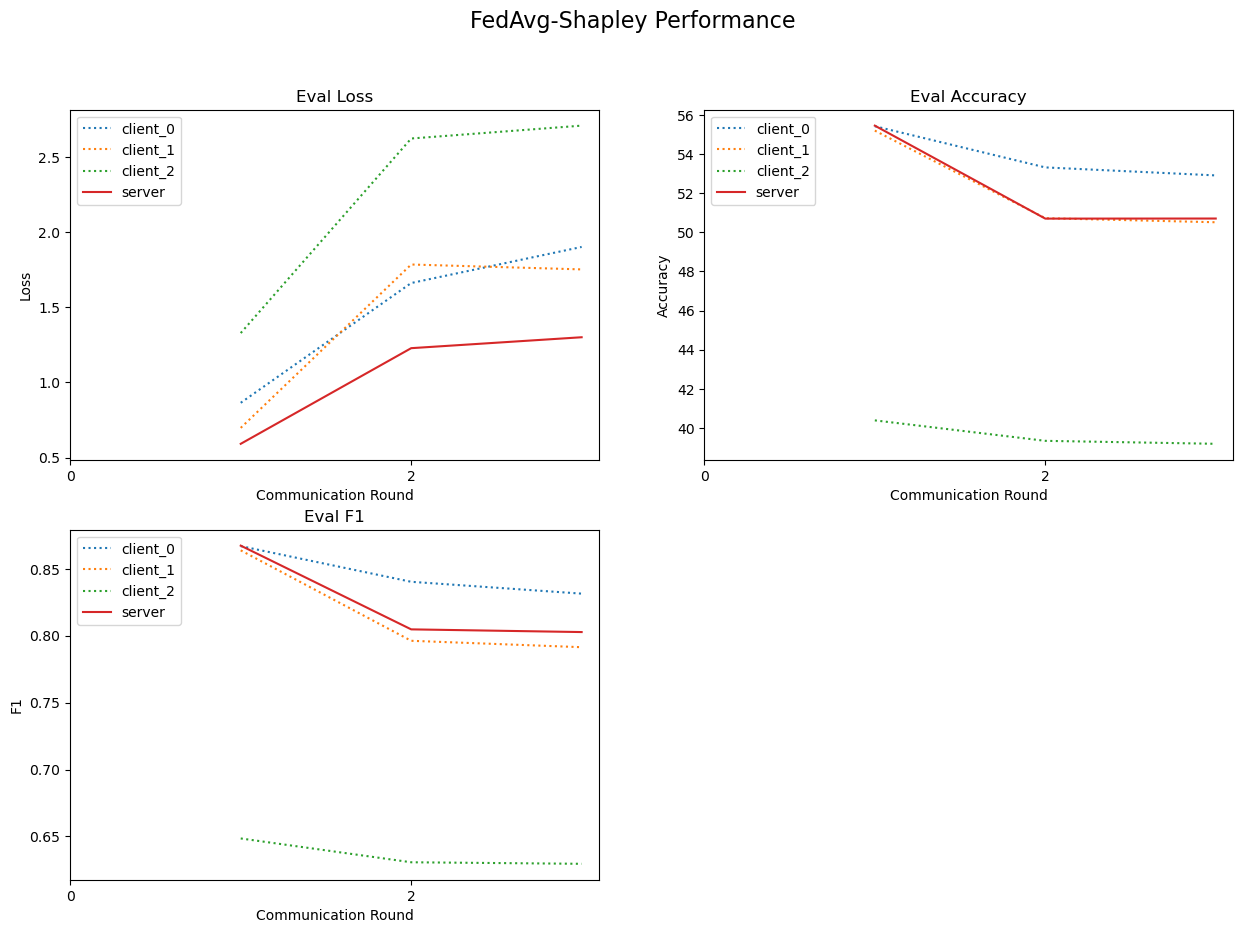


Total Shapley Value Payout: 0.568568


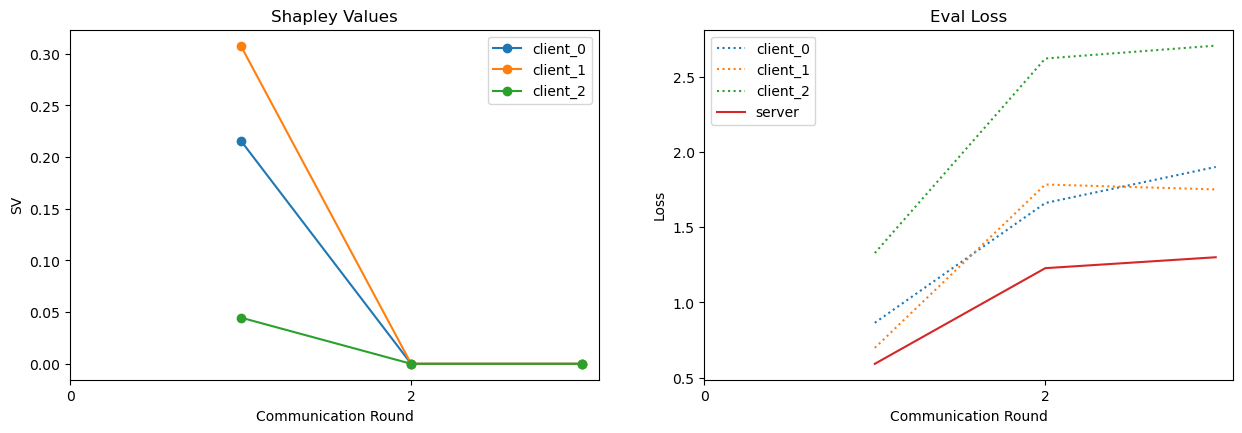

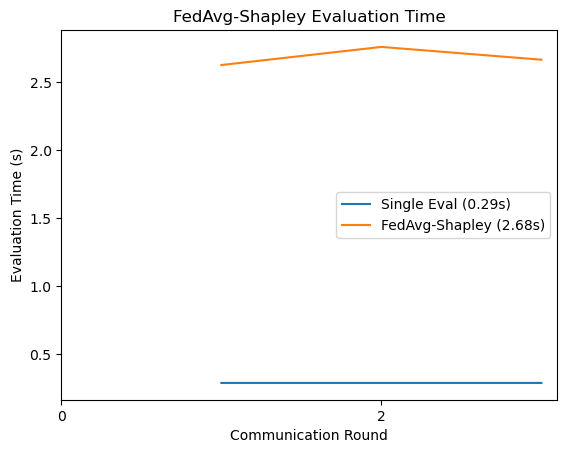

In [47]:
# Plot evaluation metric figures
figure = plt.figure(figsize=(15, 10))

# Plot Training Loss
figure.add_subplot(2, 2, 1)
for name, ts in sv_loss.items():
    if name == 'server':
        plt.plot(range(1,len(ts)+1), ts, label=name)
    else:
        plt.plot(range(1,len(ts)+1), ts, ':', label=name)
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('Loss')
plt.legend()
plt.title('Eval Loss')

# Plot Training Accuracy
figure.add_subplot(2, 2, 2)
for name, ts in sv_acc.items():
    if name == 'server':
        plt.plot(range(1,len(ts)+1), ts, label=name)
    else:
        plt.plot(range(1,len(ts)+1), ts, ':', label=name)
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Eval Accuracy')

# Plot Training F1
figure.add_subplot(2, 2, 3)
for name, ts in sv_f1.items():
    if name == 'server':
        plt.plot(range(1,len(ts)+1), ts, label=name)
    else:
        plt.plot(range(1,len(ts)+1), ts, ':', label=name)
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('F1')
plt.legend()
plt.title('Eval F1')
figure.suptitle('FedAvg-Shapley Performance', fontsize=16)
plt.show()

print()

# Plot Shapley Value figures
figure = plt.figure(figsize=(15, 10))

# Plot Shapley Values
figure.add_subplot(2, 2, 1)
sv_total = 0
for name, ts in sv.items():
    sv_total += sum(ts)
    plt.plot(range(1,len(ts)+1), ts, 'o-', label=name)
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('SV')
plt.legend()
plt.title('Shapley Values')

print(f'Total Shapley Value Payout: {sv_total:>8f}')

# Plot Best Coalition Sizes
''' figure.add_subplot(2, 2, 2)
name2int = [len(name.split('-')) if not name == 'server' else 0 for name in sv_best_coalitions]
plt.plot(range(1,len(name2int)+1), [len(clients) for name in name2int], ':', label='Number of Clients')
plt.plot(range(1,len(name2int)+1), name2int, 'o-', label='Best Coalition Size')
plt.xticks(np.arange(0, len(name2int)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('Best Coalition Size')
plt.legend()
plt.title('Best Coalition Size per Communication Round') '''
name2int = [len(name.split('-')) if not name == 'server' else 0 for name in sv_best_coalitions]

# Plot Training Loss
figure.add_subplot(2, 2, 2)
for name, ts in sv_loss.items():
    if name == 'server':
        plt.plot(range(1,len(ts)+1), ts, label=name)
    else:
        plt.plot(range(1,len(ts)+1), ts, ':', label=name)
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('Loss')
plt.legend()
plt.title('Eval Loss')

# figure.suptitle('FedAvg-Shapley SV Evaluations', fontsize=16)
plt.show()

print()

# Plot Evaluation Time
plt.plot(range(1,len(fedavg_time)+1), fedavg_time, label=f'Single Eval ({sum(fedavg_time)/len(fedavg_time):.2f}s)')
plt.plot(range(1,len(sv_time)+1), sv_time, label=f'FedAvg-Shapley ({sum(sv_time)/len(sv_time):.2f}s)')
plt.xticks(np.arange(0, len(sv_time)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('Evaluation Time (s)')
plt.legend()
plt.title(f'FedAvg-Shapley Evaluation Time')

plt.show()